Epoch [1/40]


Training Loss: 0.0823, Testing Loss: 0.0737
Epoch [2/40]


Training Loss: 0.0709, Testing Loss: 0.0686
Epoch [3/40]


Training Loss: 0.0669, Testing Loss: 0.0657
Epoch [4/40]


Training Loss: 0.0645, Testing Loss: 0.0637
Epoch [5/40]


Training Loss: 0.0623, Testing Loss: 0.0609
Epoch [6/40]


Training Loss: 0.0593, Testing Loss: 0.0579
Epoch [7/40]


Training Loss: 0.0564, Testing Loss: 0.0549
Epoch [8/40]


Training Loss: 0.0538, Testing Loss: 0.0526
Epoch [9/40]


Training Loss: 0.0514, Testing Loss: 0.0506
Epoch [10/40]


Training Loss: 0.0496, Testing Loss: 0.0490
Epoch [11/40]


Training Loss: 0.0483, Testing Loss: 0.0476
Epoch [12/40]


Training Loss: 0.0471, Testing Loss: 0.0463
Epoch [13/40]


Training Loss: 0.0462, Testing Loss: 0.0460
Epoch [14/40]


Training Loss: 0.0456, Testing Loss: 0.0452
Epoch [15/40]


Training Loss: 0.0450, Testing Loss: 0.0449
Epoch [16/40]


Training Loss: 0.0446, Testing Loss: 0.0445
Epoch [17/40]


Training Loss: 0.0442, Testing Loss: 0.0443
Epoch [18/40]


Training Loss: 0.0440, Testing Loss: 0.0440
Epoch [19/40]


Training Loss: 0.0438, Testing Loss: 0.0435
Epoch [20/40]


Training Loss: 0.0436, Testing Loss: 0.0439
Epoch [21/40]


Training Loss: 0.0434, Testing Loss: 0.0433
Epoch [22/40]


Training Loss: 0.0433, Testing Loss: 0.0430
Epoch [23/40]


Training Loss: 0.0432, Testing Loss: 0.0430
Epoch [24/40]


Training Loss: 0.0431, Testing Loss: 0.0431
Epoch [25/40]


Training Loss: 0.0430, Testing Loss: 0.0428
Epoch [26/40]


Training Loss: 0.0430, Testing Loss: 0.0433
Epoch [27/40]


Training Loss: 0.0429, Testing Loss: 0.0427
Epoch [28/40]


Training Loss: 0.0428, Testing Loss: 0.0425
Epoch [29/40]


Training Loss: 0.0427, Testing Loss: 0.0431
Epoch [30/40]


Training Loss: 0.0427, Testing Loss: 0.0427
Epoch [31/40]


Training Loss: 0.0426, Testing Loss: 0.0424
Epoch [32/40]


Training Loss: 0.0426, Testing Loss: 0.0424
Epoch [33/40]


Training Loss: 0.0425, Testing Loss: 0.0426
Epoch [34/40]


Training Loss: 0.0424, Testing Loss: 0.0427
Epoch [35/40]


Training Loss: 0.0424, Testing Loss: 0.0429
Epoch [36/40]


Training Loss: 0.0424, Testing Loss: 0.0421
Epoch [37/40]


Training Loss: 0.0423, Testing Loss: 0.0424
Epoch [38/40]


Training Loss: 0.0422, Testing Loss: 0.0422
Epoch [39/40]


Training Loss: 0.0422, Testing Loss: 0.0421
Epoch [40/40]


Training Loss: 0.0421, Testing Loss: 0.0419


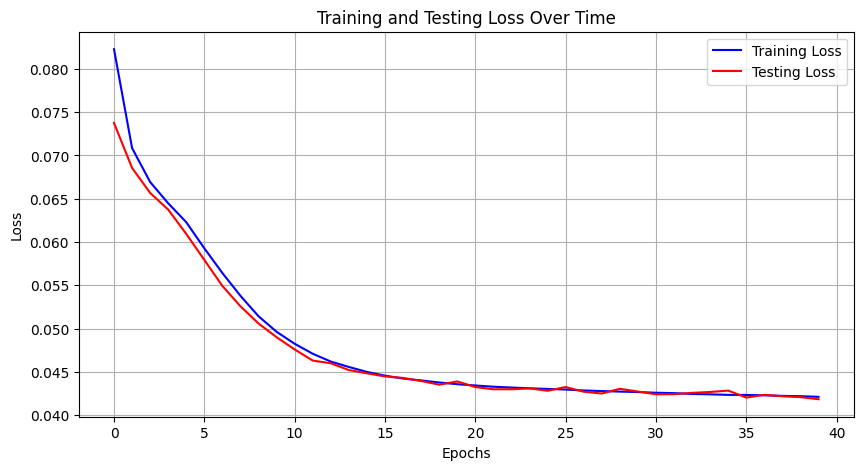

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define the Sudoku dataset class
class SudokuDataset(Dataset):
    def __init__(self, puzzles, solutions):
        self.puzzles = puzzles
        self.solutions = solutions
    
    def __len__(self):
        return len(self.puzzles)
    
    def __getitem__(self, idx):
        puzzle = self.puzzles[idx]
        solution = self.solutions[idx]
        return puzzle, solution

# Load the dataset from the .pt file
dataset_path = 'SudokuData/sudoku_dataset.pt'
sudoku_data = torch.load(dataset_path)

# Extract puzzles and solutions from the dataset
puzzles = sudoku_data['puzzles']
solutions = sudoku_data['solutions']

# Create the dataset and split into training and testing sets (80% training, 20% testing)
dataset = SudokuDataset(puzzles, solutions)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=1000, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Define a simple fully connected neural network
class SimpleSudokuNet(nn.Module):
    def __init__(self):
        super(SimpleSudokuNet, self).__init__()
        # Input is 81 (9x9), output is 81 (solved 9x9)
        self.fc1 = nn.Linear(81, 128)  # Fully connected layer with 128 units
        self.fc2 = nn.Linear(128, 128)  # Hidden layer with 64 units
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, 512)
        self.fc5 = nn.Linear(512, 256)
        self.fc6 = nn.Linear(256, 128)
        self.fc7 = nn.Linear(128, 81)   # Output layer with 81 units (9x9)
        self.relu = nn.ReLU()          # Activation function

    def forward(self, x):
        x = x.view(-1, 81)  # Flatten the 9x9 puzzle into 81 elements
        x = self.relu(self.fc1(x))  # First layer with ReLU
        x = self.relu(self.fc2(x))  # Second layer with ReLU
        x = self.relu(self.fc3(x))             # Output layer (no activation for regression)
        x = self.relu(self.fc4(x))  
        x = self.relu(self.fc5(x)) 
        x = self.relu(self.fc6(x)) 
        x = self.fc7(x)
        return x.view(-1, 9, 9)     # Reshape output to 9x9 grid

# Instantiate the model, define loss function and optimizer
model = SimpleSudokuNet()
criterion = nn.MSELoss()  # Mean Squared Error Loss for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to track the loss for plotting
train_losses = []
test_losses = []

# Training and Testing loop with loading bar and loss visualization
num_epochs = 40
for epoch in range(num_epochs):
    print(f'Epoch [{epoch+1}/{num_epochs}]')

    # Training Phase
    model.train()  # Set the model to training mode
    train_loss = 0.0
    for batch_puzzles, batch_solutions in tqdm(train_loader, desc="Training", leave=False):
        # Flatten and normalize the puzzles
        batch_puzzles = batch_puzzles.view(-1, 81).float() / 9
        batch_solutions = batch_solutions.view(-1, 81).float() / 9
        
        # Forward pass through the model
        outputs = model(batch_puzzles)
        loss = criterion(outputs, batch_solutions.view(-1, 9, 9))
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * batch_puzzles.size(0)  # Accumulate loss

    # Average train loss for the epoch
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Testing Phase
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    with torch.no_grad():  # No need to track gradients during testing
        for batch_puzzles, batch_solutions in tqdm(test_loader, desc="Testing", leave=False):
            batch_puzzles = batch_puzzles.view(-1, 81).float() / 9
            batch_solutions = batch_solutions.view(-1, 81).float() / 9

            # Forward pass
            outputs = model(batch_puzzles)
            loss = criterion(outputs, batch_solutions.view(-1, 9, 9))

            test_loss += loss.item() * batch_puzzles.size(0)  # Accumulate test loss

    # Average test loss for the epoch
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    # Print losses for the epoch
    print(f'Training Loss: {train_loss:.4f}, Testing Loss: {test_loss:.4f}')

# Plot the loss curves for training and testing
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(test_losses, label='Testing Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()


In [30]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Assuming you already have the SimpleSudokuNet and SudokuDataset from the previous code

# Function to test the model on n samples from the test dataset
def test_model(model, test_loader, n):
    model.eval()  # Set model to evaluation mode
    total_correct = 0
    total_cells = 0

    with torch.no_grad():  # No need to compute gradients during testing
        for i, (puzzles, solutions) in enumerate(test_loader):
            if i * puzzles.size(0) >= n:
                break  # Stop when we've tested n samples
            
            # Normalize puzzles and solutions
            puzzles = puzzles.view(-1, 81).float() / 9  # Normalized between 0 and 1
            solutions = solutions.view(-1, 81).float()  # Original solutions
            
            # Forward pass
            outputs = model(puzzles)  # Model prediction
            outputs = outputs.view(-1, 81)  # Flatten output to (batch_size, 81)
            
            # De-normalize and round predictions
            predicted = torch.round(outputs * 9).clamp(0, 9)  # Round and clip between 0-9
            true_values = solutions.view(-1, 81)  # Flatten true solutions
            
            # Calculate number of correct guesses (element-wise comparison)
            correct = (predicted == true_values).sum().item()  # Count correct guesses
            total_correct += correct
            total_cells += predicted.numel()  # Total number of cells processed

    # Calculate accuracy as a percentage of correct guesses
    accuracy = (total_correct / total_cells) * 100
    print(f"Test Accuracy on {n} samples: {accuracy:.2f}%")
    return accuracy

# Example usage of the test_model function
# Set the number of samples to test (n)
n_samples_to_test = 1000  # Adjust this as needed

# Load the dataset (replace with actual DataLoader object)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Assuming your model is already trained, now test it
test_accuracy = test_model(model, test_loader, n_samples_to_test)


Test Accuracy on 1000 samples: 41.07%


Using device: cuda
Epoch [1/250]


Training Loss: 0.0858, Testing Loss: 0.0824
Epoch [2/250]


Training Loss: 0.0821, Testing Loss: 0.0820
Epoch [3/250]


Training Loss: 0.0812, Testing Loss: 0.0801
Epoch [4/250]


Training Loss: 0.0789, Testing Loss: 0.0776
Epoch [5/250]


Training Loss: 0.0758, Testing Loss: 0.0749
Epoch [6/250]


Training Loss: 0.0739, Testing Loss: 0.0734
Epoch [7/250]


Training Loss: 0.0727, Testing Loss: 0.0719
Epoch [8/250]


Training Loss: 0.0717, Testing Loss: 0.0717
Epoch [9/250]


Training Loss: 0.0714, Testing Loss: 0.0711
Epoch [10/250]


Training Loss: 0.0706, Testing Loss: 0.0700
Epoch [11/250]


Training Loss: 0.0697, Testing Loss: 0.0695
Epoch [12/250]


Training Loss: 0.0693, Testing Loss: 0.0691
Epoch [13/250]


Training Loss: 0.0689, Testing Loss: 0.0687
Epoch [14/250]


Training Loss: 0.0686, Testing Loss: 0.0684
Epoch [15/250]


Training Loss: 0.0682, Testing Loss: 0.0680
Epoch [16/250]


Training Loss: 0.0676, Testing Loss: 0.0675
Epoch [17/250]


Training Loss: 0.0675, Testing Loss: 0.0675
Epoch [18/250]


Training Loss: 0.0671, Testing Loss: 0.0666
Epoch [19/250]


Training Loss: 0.0664, Testing Loss: 0.0663
Epoch [20/250]


Training Loss: 0.0663, Testing Loss: 0.0664
Epoch [21/250]


Training Loss: 0.0663, Testing Loss: 0.0662
Epoch [22/250]


Training Loss: 0.0659, Testing Loss: 0.0655
Epoch [23/250]


Training Loss: 0.0651, Testing Loss: 0.0650
Epoch [24/250]


Training Loss: 0.0648, Testing Loss: 0.0647
Epoch [25/250]


Training Loss: 0.0648, Testing Loss: 0.0648
Epoch [26/250]


Training Loss: 0.0646, Testing Loss: 0.0643
Epoch [27/250]


Training Loss: 0.0640, Testing Loss: 0.0638
Epoch [28/250]


Training Loss: 0.0637, Testing Loss: 0.0636
Epoch [29/250]


Training Loss: 0.0635, Testing Loss: 0.0636
Epoch [30/250]


Training Loss: 0.0635, Testing Loss: 0.0638
Epoch [31/250]


Training Loss: 0.0634, Testing Loss: 0.0637
Epoch [32/250]


Training Loss: 0.0634, Testing Loss: 0.0641
Epoch [33/250]


Training Loss: 0.0630, Testing Loss: 0.0627
Epoch [34/250]


Training Loss: 0.0628, Testing Loss: 0.0627
Epoch [35/250]


Training Loss: 0.0627, Testing Loss: 0.0627
Epoch [36/250]


Training Loss: 0.0627, Testing Loss: 0.0628
Epoch [37/250]


Training Loss: 0.0626, Testing Loss: 0.0627
Epoch [38/250]


Training Loss: 0.0626, Testing Loss: 0.0627
Epoch [39/250]


Training Loss: 0.0626, Testing Loss: 0.0626
Epoch [40/250]


Training Loss: 0.0626, Testing Loss: 0.0626
Epoch [41/250]


Training Loss: 0.0625, Testing Loss: 0.0622
Epoch [42/250]


Training Loss: 0.0623, Testing Loss: 0.0623
Epoch [43/250]


Training Loss: 0.0622, Testing Loss: 0.0623
Epoch [44/250]


Training Loss: 0.0622, Testing Loss: 0.0626
Epoch [45/250]


Training Loss: 0.0621, Testing Loss: 0.0619
Epoch [46/250]


Training Loss: 0.0619, Testing Loss: 0.0619
Epoch [47/250]


Training Loss: 0.0618, Testing Loss: 0.0618
Epoch [48/250]


Training Loss: 0.0617, Testing Loss: 0.0615
Epoch [49/250]


Training Loss: 0.0616, Testing Loss: 0.0614
Epoch [50/250]


Training Loss: 0.0614, Testing Loss: 0.0613
Epoch [51/250]


Training Loss: 0.0614, Testing Loss: 0.0615
Epoch [52/250]


Training Loss: 0.0613, Testing Loss: 0.0618
Epoch [53/250]


Training Loss: 0.0613, Testing Loss: 0.0614
Epoch [54/250]


Training Loss: 0.0614, Testing Loss: 0.0613
Epoch [55/250]


Training Loss: 0.0615, Testing Loss: 0.0615
Epoch [56/250]


Training Loss: 0.0614, Testing Loss: 0.0615
Epoch [57/250]


Training Loss: 0.0612, Testing Loss: 0.0610
Epoch [58/250]


Training Loss: 0.0610, Testing Loss: 0.0609
Epoch [59/250]


Training Loss: 0.0609, Testing Loss: 0.0608
Epoch [60/250]


Training Loss: 0.0606, Testing Loss: 0.0610
Epoch [61/250]


Training Loss: 0.0606, Testing Loss: 0.0605
Epoch [62/250]


Training Loss: 0.0603, Testing Loss: 0.0602
Epoch [63/250]


Training Loss: 0.0598, Testing Loss: 0.0595
Epoch [64/250]


Training Loss: 0.0593, Testing Loss: 0.0592
Epoch [65/250]


Training Loss: 0.0589, Testing Loss: 0.0588
Epoch [66/250]


Training Loss: 0.0587, Testing Loss: 0.0591
Epoch [67/250]


Training Loss: 0.0587, Testing Loss: 0.0586
Epoch [68/250]


Training Loss: 0.0586, Testing Loss: 0.0586
Epoch [69/250]


Training Loss: 0.0586, Testing Loss: 0.0586
Epoch [70/250]


Training Loss: 0.0582, Testing Loss: 0.0584
Epoch [71/250]


Training Loss: 0.0583, Testing Loss: 0.0584
Epoch [72/250]


Training Loss: 0.0582, Testing Loss: 0.0583
Epoch [73/250]


Training Loss: 0.0582, Testing Loss: 0.0583
Epoch [74/250]


Training Loss: 0.0582, Testing Loss: 0.0582
Epoch [75/250]


Training Loss: 0.0582, Testing Loss: 0.0584
Epoch [76/250]


Training Loss: 0.0581, Testing Loss: 0.0581
Epoch [77/250]


Training Loss: 0.0580, Testing Loss: 0.0583
Epoch [78/250]


Training Loss: 0.0581, Testing Loss: 0.0582
Epoch [79/250]


Training Loss: 0.0578, Testing Loss: 0.0583
Epoch [80/250]


Training Loss: 0.0576, Testing Loss: 0.0576
Epoch [81/250]


Training Loss: 0.0573, Testing Loss: 0.0574
Epoch [82/250]


Training Loss: 0.0571, Testing Loss: 0.0573
Epoch [83/250]


Training Loss: 0.0570, Testing Loss: 0.0572
Epoch [84/250]


Training Loss: 0.0569, Testing Loss: 0.0576
Epoch [85/250]


Training Loss: 0.0569, Testing Loss: 0.0570
Epoch [86/250]


Training Loss: 0.0571, Testing Loss: 0.0571
Epoch [87/250]


Training Loss: 0.0569, Testing Loss: 0.0570
Epoch [88/250]


Training Loss: 0.0570, Testing Loss: 0.0572
Epoch [89/250]


Training Loss: 0.0571, Testing Loss: 0.0572
Epoch [90/250]


Training Loss: 0.0571, Testing Loss: 0.0574
Epoch [91/250]


Training Loss: 0.0572, Testing Loss: 0.0586
Epoch [92/250]


Training Loss: 0.0571, Testing Loss: 0.0574
Epoch [93/250]


Training Loss: 0.0568, Testing Loss: 0.0573
Epoch [94/250]


Training Loss: 0.0573, Testing Loss: 0.0580
Epoch [95/250]


Training Loss: 0.0569, Testing Loss: 0.0568
Epoch [96/250]


Training Loss: 0.0569, Testing Loss: 0.0568
Epoch [97/250]


Training Loss: 0.0565, Testing Loss: 0.0565
Epoch [98/250]


Training Loss: 0.0565, Testing Loss: 0.0566
Epoch [99/250]


Training Loss: 0.0565, Testing Loss: 0.0567
Epoch [100/250]


Training Loss: 0.0564, Testing Loss: 0.0566
Epoch [101/250]


Training Loss: 0.0567, Testing Loss: 0.0570
Epoch [102/250]


Training Loss: 0.0565, Testing Loss: 0.0565
Epoch [103/250]


Training Loss: 0.0561, Testing Loss: 0.0561
Epoch [104/250]


Training Loss: 0.0560, Testing Loss: 0.0564
Epoch [105/250]


Training Loss: 0.0558, Testing Loss: 0.0559
Epoch [106/250]


Training Loss: 0.0557, Testing Loss: 0.0561
Epoch [107/250]


Training Loss: 0.0556, Testing Loss: 0.0556
Epoch [108/250]


Training Loss: 0.0555, Testing Loss: 0.0562
Epoch [109/250]


Training Loss: 0.0552, Testing Loss: 0.0557
Epoch [110/250]


Training Loss: 0.0547, Testing Loss: 0.0547
Epoch [111/250]


Training Loss: 0.0546, Testing Loss: 0.0546
Epoch [112/250]


Training Loss: 0.0544, Testing Loss: 0.0544
Epoch [113/250]


Training Loss: 0.0544, Testing Loss: 0.0543
Epoch [114/250]


Training Loss: 0.0541, Testing Loss: 0.0542
Epoch [115/250]


Training Loss: 0.0541, Testing Loss: 0.0544
Epoch [116/250]


Training Loss: 0.0541, Testing Loss: 0.0542
Epoch [117/250]


Training Loss: 0.0541, Testing Loss: 0.0540
Epoch [118/250]


Training Loss: 0.0539, Testing Loss: 0.0539
Epoch [119/250]


Training Loss: 0.0539, Testing Loss: 0.0540
Epoch [120/250]


Training Loss: 0.0538, Testing Loss: 0.0546
Epoch [121/250]


Training Loss: 0.0538, Testing Loss: 0.0538
Epoch [122/250]


Training Loss: 0.0538, Testing Loss: 0.0540
Epoch [123/250]


Training Loss: 0.0538, Testing Loss: 0.0539
Epoch [124/250]


Training Loss: 0.0537, Testing Loss: 0.0539
Epoch [125/250]


Training Loss: 0.0537, Testing Loss: 0.0538
Epoch [126/250]


Training Loss: 0.0536, Testing Loss: 0.0538
Epoch [127/250]


Training Loss: 0.0535, Testing Loss: 0.0535
Epoch [128/250]


Training Loss: 0.0534, Testing Loss: 0.0533
Epoch [129/250]


Training Loss: 0.0534, Testing Loss: 0.0534
Epoch [130/250]


Training Loss: 0.0535, Testing Loss: 0.0535
Epoch [131/250]


Training Loss: 0.0532, Testing Loss: 0.0532
Epoch [132/250]


Training Loss: 0.0532, Testing Loss: 0.0531
Epoch [133/250]


Training Loss: 0.0529, Testing Loss: 0.0532
Epoch [134/250]


Training Loss: 0.0530, Testing Loss: 0.0533
Epoch [135/250]


Training Loss: 0.0530, Testing Loss: 0.0530
Epoch [136/250]


Training Loss: 0.0529, Testing Loss: 0.0535
Epoch [137/250]


Training Loss: 0.0526, Testing Loss: 0.0529
Epoch [138/250]


Training Loss: 0.0528, Testing Loss: 0.0529
Epoch [139/250]


Training Loss: 0.0528, Testing Loss: 0.0553
Epoch [140/250]


Training Loss: 0.0529, Testing Loss: 0.0526
Epoch [141/250]


Training Loss: 0.0525, Testing Loss: 0.0526
Epoch [142/250]


Training Loss: 0.0527, Testing Loss: 0.0526
Epoch [143/250]


Training Loss: 0.0524, Testing Loss: 0.0527
Epoch [144/250]


Training Loss: 0.0530, Testing Loss: 0.0532
Epoch [145/250]


Training Loss: 0.0527, Testing Loss: 0.0529
Epoch [146/250]


Training Loss: 0.0527, Testing Loss: 0.0531
Epoch [147/250]


Training Loss: 0.0526, Testing Loss: 0.0529
Epoch [148/250]


Training Loss: 0.0526, Testing Loss: 0.0529
Epoch [149/250]


Training Loss: 0.0525, Testing Loss: 0.0527
Epoch [150/250]


Training Loss: 0.0524, Testing Loss: 0.0525
Epoch [151/250]


Training Loss: 0.0521, Testing Loss: 0.0524
Epoch [152/250]


Training Loss: 0.0521, Testing Loss: 0.0523
Epoch [153/250]


Training Loss: 0.0521, Testing Loss: 0.0522
Epoch [154/250]


Training Loss: 0.0522, Testing Loss: 0.0525
Epoch [155/250]


Training Loss: 0.0521, Testing Loss: 0.0521
Epoch [156/250]


Training Loss: 0.0520, Testing Loss: 0.0522
Epoch [157/250]


Training Loss: 0.0521, Testing Loss: 0.0524
Epoch [158/250]


Training Loss: 0.0520, Testing Loss: 0.0524
Epoch [159/250]


Training Loss: 0.0522, Testing Loss: 0.0522
Epoch [160/250]


Training Loss: 0.0521, Testing Loss: 0.0525
Epoch [161/250]


Training Loss: 0.0521, Testing Loss: 0.0532
Epoch [162/250]


Training Loss: 0.0520, Testing Loss: 0.0521
Epoch [163/250]


Training Loss: 0.0517, Testing Loss: 0.0518
Epoch [164/250]


Training Loss: 0.0513, Testing Loss: 0.0515
Epoch [165/250]


Training Loss: 0.0511, Testing Loss: 0.0512
Epoch [166/250]


Training Loss: 0.0508, Testing Loss: 0.0509
Epoch [167/250]


Training Loss: 0.0505, Testing Loss: 0.0506
Epoch [168/250]


Training Loss: 0.0504, Testing Loss: 0.0505
Epoch [169/250]


Training Loss: 0.0505, Testing Loss: 0.0507
Epoch [170/250]


Training Loss: 0.0503, Testing Loss: 0.0507
Epoch [171/250]


Training Loss: 0.0502, Testing Loss: 0.0507
Epoch [172/250]


Training Loss: 0.0501, Testing Loss: 0.0502
Epoch [173/250]


Training Loss: 0.0499, Testing Loss: 0.0502
Epoch [174/250]


Training Loss: 0.0498, Testing Loss: 0.0501
Epoch [175/250]


Training Loss: 0.0497, Testing Loss: 0.0499
Epoch [176/250]


Training Loss: 0.0498, Testing Loss: 0.0498
Epoch [177/250]


Training Loss: 0.0497, Testing Loss: 0.0499
Epoch [178/250]


Training Loss: 0.0497, Testing Loss: 0.0500
Epoch [179/250]


Training Loss: 0.0496, Testing Loss: 0.0499
Epoch [180/250]


Training Loss: 0.0496, Testing Loss: 0.0498
Epoch [181/250]


Training Loss: 0.0496, Testing Loss: 0.0501
Epoch [182/250]


Training Loss: 0.0496, Testing Loss: 0.0498
Epoch [183/250]


Training Loss: 0.0497, Testing Loss: 0.0498
Epoch [184/250]


Training Loss: 0.0496, Testing Loss: 0.0496
Epoch [185/250]


Training Loss: 0.0496, Testing Loss: 0.0497
Epoch [186/250]


Training Loss: 0.0496, Testing Loss: 0.0496
Epoch [187/250]


Training Loss: 0.0496, Testing Loss: 0.0496
Epoch [188/250]


Training Loss: 0.0494, Testing Loss: 0.0497
Epoch [189/250]


Training Loss: 0.0493, Testing Loss: 0.0495
Epoch [190/250]


Training Loss: 0.0492, Testing Loss: 0.0497
Epoch [191/250]


Training Loss: 0.0491, Testing Loss: 0.0500
Epoch [192/250]


Training Loss: 0.0492, Testing Loss: 0.0497
Epoch [193/250]


Training Loss: 0.0489, Testing Loss: 0.0490
Epoch [194/250]


Training Loss: 0.0490, Testing Loss: 0.0490
Epoch [195/250]


Training Loss: 0.0489, Testing Loss: 0.0492
Epoch [196/250]


Training Loss: 0.0488, Testing Loss: 0.0491
Epoch [197/250]


Training Loss: 0.0489, Testing Loss: 0.0491
Epoch [198/250]


Training Loss: 0.0490, Testing Loss: 0.0495
Epoch [199/250]


Training Loss: 0.0492, Testing Loss: 0.0493
Epoch [200/250]


Training Loss: 0.0489, Testing Loss: 0.0490
Epoch [201/250]


Training Loss: 0.0488, Testing Loss: 0.0508
Epoch [202/250]


Training Loss: 0.0489, Testing Loss: 0.0491
Epoch [203/250]


Training Loss: 0.0486, Testing Loss: 0.0488
Epoch [204/250]


Training Loss: 0.0491, Testing Loss: 0.0487
Epoch [205/250]


Training Loss: 0.0485, Testing Loss: 0.0485
Epoch [206/250]


Training Loss: 0.0484, Testing Loss: 0.0487
Epoch [207/250]


Training Loss: 0.0486, Testing Loss: 0.0492
Epoch [208/250]


Training Loss: 0.0490, Testing Loss: 0.0493
Epoch [209/250]


Training Loss: 0.0488, Testing Loss: 0.0488
Epoch [210/250]


Training Loss: 0.0486, Testing Loss: 0.0494
Epoch [211/250]


Training Loss: 0.0487, Testing Loss: 0.0489
Epoch [212/250]


Training Loss: 0.0486, Testing Loss: 0.0487
Epoch [213/250]


Training Loss: 0.0484, Testing Loss: 0.0488
Epoch [214/250]


Training Loss: 0.0487, Testing Loss: 0.0488
Epoch [215/250]


Training Loss: 0.0486, Testing Loss: 0.0487
Epoch [216/250]


Training Loss: 0.0486, Testing Loss: 0.0489
Epoch [217/250]


Training Loss: 0.0487, Testing Loss: 0.0492
Epoch [218/250]


Training Loss: 0.0486, Testing Loss: 0.0486
Epoch [219/250]


Training Loss: 0.0486, Testing Loss: 0.0489
Epoch [220/250]


Training Loss: 0.0485, Testing Loss: 0.0487
Epoch [221/250]


Training Loss: 0.0485, Testing Loss: 0.0487
Epoch [222/250]


Training Loss: 0.0484, Testing Loss: 0.0485
Epoch [223/250]


Training Loss: 0.0484, Testing Loss: 0.0495
Epoch [224/250]


Training Loss: 0.0485, Testing Loss: 0.0492
Epoch [225/250]


Training Loss: 0.0485, Testing Loss: 0.0486
Epoch [226/250]


Training Loss: 0.0486, Testing Loss: 0.0489
Epoch [227/250]


Training Loss: 0.0487, Testing Loss: 0.0489
Epoch [228/250]


Training Loss: 0.0486, Testing Loss: 0.0487
Epoch [229/250]


Training Loss: 0.0484, Testing Loss: 0.0485
Epoch [230/250]


Training Loss: 0.0484, Testing Loss: 0.0482
Epoch [231/250]


Training Loss: 0.0481, Testing Loss: 0.0482
Epoch [232/250]


Training Loss: 0.0481, Testing Loss: 0.0486
Epoch [233/250]


Training Loss: 0.0481, Testing Loss: 0.0484
Epoch [234/250]


Training Loss: 0.0481, Testing Loss: 0.0482
Epoch [235/250]


Training Loss: 0.0479, Testing Loss: 0.0484
Epoch [236/250]


Training Loss: 0.0480, Testing Loss: 0.0482
Epoch [237/250]


Training Loss: 0.0480, Testing Loss: 0.0481
Epoch [238/250]


Training Loss: 0.0477, Testing Loss: 0.0478
Epoch [239/250]


Training Loss: 0.0477, Testing Loss: 0.0496
Epoch [240/250]


Training Loss: 0.0477, Testing Loss: 0.0479
Epoch [241/250]


Training Loss: 0.0477, Testing Loss: 0.0481
Epoch [242/250]


Training Loss: 0.0477, Testing Loss: 0.0478
Epoch [243/250]


Training Loss: 0.0476, Testing Loss: 0.0478
Epoch [244/250]


Training Loss: 0.0477, Testing Loss: 0.0477
Epoch [245/250]


Training Loss: 0.0476, Testing Loss: 0.0476
Epoch [246/250]


Training Loss: 0.0475, Testing Loss: 0.0478
Epoch [247/250]


Training Loss: 0.0475, Testing Loss: 0.0476
Epoch [248/250]


Training Loss: 0.0474, Testing Loss: 0.0475
Epoch [249/250]


Training Loss: 0.0473, Testing Loss: 0.0475
Epoch [250/250]


Training Loss: 0.0472, Testing Loss: 0.0473


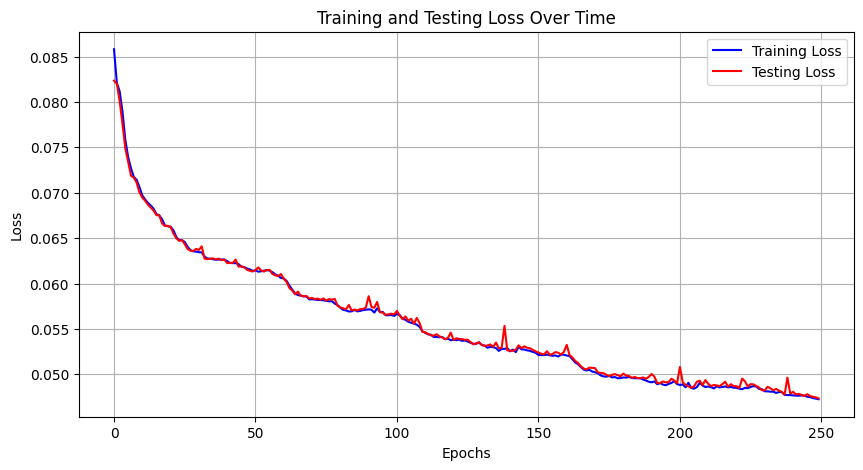

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define the Sudoku dataset class
class SudokuDataset(Dataset):
    def __init__(self, puzzles, solutions):
        self.puzzles = puzzles
        self.solutions = solutions

    def __len__(self):
        return len(self.puzzles)

    def __getitem__(self, idx):
        puzzle = self.puzzles[idx]
        solution = self.solutions[idx]
        return puzzle, solution

# Load the dataset from the .pt file
dataset_path = 'SudokuData/sudoku_dataset.pt'
sudoku_data = torch.load(dataset_path)

# Extract puzzles and solutions from the dataset
puzzles = sudoku_data['puzzles']
solutions = sudoku_data['solutions']

# Create the dataset and split into training and testing sets (80% training, 20% testing)
dataset = SudokuDataset(puzzles, solutions)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=1000, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Define a simple fully connected neural network
class SimpleSudokuNet(nn.Module):
    def __init__(self):
        super(SimpleSudokuNet, self).__init__()
        # Input is 81 (9x9), output is 81 (solved 9x9)
        self.fc1 = nn.Linear(81, 128)  # Fully connected layer with 128 units
        self.fc2 = nn.Linear(128, 128)  # Hidden layer with 64 units
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, 512)
        self.fc5 = nn.Linear(512, 1024)
        self.fc6 = nn.Linear(1024, 1024)
        self.fc7 = nn.Linear(1024, 512)
        self.fc8 = nn.Linear(512, 256)
        self.fc9 = nn.Linear(256, 128)
        self.fc10 = nn.Linear(128, 81)   # Output layer with 81 units (9x9)
        self.relu = nn.ReLU()          # Activation function

    def forward(self, x):
        x = x.view(-1, 81)  # Flatten the 9x9 puzzle into 81 elements
        x = self.relu(self.fc1(x))  # First layer with ReLU
        x = self.relu(self.fc2(x))  # Second layer with ReLU
        x = self.relu(self.fc3(x))             # Output layer (no activation for regression)
        x = self.relu(self.fc4(x))  
        x = self.relu(self.fc5(x)) 
        x = self.relu(self.fc6(x)) 
        x = self.relu(self.fc7(x)) 
        x = self.relu(self.fc8(x))
        x = self.relu(self.fc9(x))  
        x = self.fc10(x)
        return x.view(-1, 9, 9)     # Reshape output to 9x9 grid

# Check if CUDA is available, and use it if it is
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Instantiate the model, move it to the GPU if available
model = SimpleSudokuNet().to(device)
criterion = nn.MSELoss()  # Mean Squared Error Loss for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to track the loss for plotting
train_losses = []
test_losses = []

# Training and Testing loop with loading bar and loss visualization
num_epochs = 250
for epoch in range(num_epochs):
    print(f'Epoch [{epoch+1}/{num_epochs}]')

    # Training Phase
    model.train()  # Set the model to training mode
    train_loss = 0.0
    for batch_puzzles, batch_solutions in tqdm(train_loader, desc="Training", leave=False):
        # Move data to the device (GPU if available)
        batch_puzzles = batch_puzzles.view(-1, 81).float().to(device) / 9
        batch_solutions = batch_solutions.view(-1, 81).float().to(device) / 9
        
        # Forward pass through the model
        outputs = model(batch_puzzles)
        loss = criterion(outputs, batch_solutions.view(-1, 9, 9))
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * batch_puzzles.size(0)  # Accumulate loss

    # Average train loss for the epoch
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Testing Phase
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    with torch.no_grad():  # No need to track gradients during testing
        for batch_puzzles, batch_solutions in tqdm(test_loader, desc="Testing", leave=False):
            batch_puzzles = batch_puzzles.view(-1, 81).float().to(device) / 9
            batch_solutions = batch_solutions.view(-1, 81).float().to(device) / 9

            # Forward pass
            outputs = model(batch_puzzles)
            loss = criterion(outputs, batch_solutions.view(-1, 9, 9))

            test_loss += loss.item() * batch_puzzles.size(0)  # Accumulate test loss

    # Average test loss for the epoch
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    # Print losses for the epoch
    print(f'Training Loss: {train_loss:.4f}, Testing Loss: {test_loss:.4f}')

# Plot the loss curves for training and testing
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(test_losses, label='Testing Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()


The increase of complexity of normal linear network bring me to maximall accuracy of 40% so it is not what i am trying to achive here 



In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Function to test the model on n samples from the test dataset, utilizing GPU if available
def test_model(model, test_loader, n, device):
    model.eval()  # Set model to evaluation mode
    model.to(device)  # Move the model to the device (GPU or CPU)
    
    total_correct = 0
    total_cells = 0

    with torch.no_grad():  # No need to compute gradients during testing
        for i, (puzzles, solutions) in enumerate(test_loader):
            if i * puzzles.size(0) >= n:
                break  # Stop when we've tested n samples

            # Move puzzles and solutions to the device (GPU or CPU)
            puzzles = puzzles.view(-1, 81).float().to(device) / 9  # Normalized between 0 and 1
            solutions = solutions.view(-1, 81).float().to(device)  # Original solutions

            # Forward pass
            outputs = model(puzzles)  # Model prediction
            outputs = outputs.view(-1, 81)  # Flatten output to (batch_size, 81)

            # De-normalize and round predictions
            predicted = torch.round(outputs * 9).clamp(0, 9)  # Round and clip between 0-9
            true_values = solutions.view(-1, 81)  # Flatten true solutions

            # Calculate number of correct guesses (element-wise comparison)
            correct = (predicted == true_values).sum().item()  # Count correct guesses
            total_correct += correct
            total_cells += predicted.numel()  # Total number of cells processed

    # Calculate accuracy as a percentage of correct guesses
    accuracy = (total_correct / total_cells) * 100
    print(f"Test Accuracy on {n} samples: {accuracy:.2f}%")
    return accuracy

# Example usage of the test_model function
# Set the number of samples to test (n)
n_samples_to_test = 10000  # Adjust this as needed

# Check if a GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the dataset (replace with actual DataLoader object)
test_loader = DataLoader(test_dataset, batch_size=10000, shuffle=False)

# Assuming your model is already trained, now test it
test_accuracy = test_model(model, test_loader, n_samples_to_test, device)


Test Accuracy on 10000 samples: 43.47%


Even with increasing the complexity of the model the best accuracy is about 40% , and the cnn would work way better on data type like this 

Using device: cuda
Epoch [1/3]


Training Loss: 0.0351, Testing Loss: 0.0218
Epoch [2/3]


Training Loss: 0.0211, Testing Loss: 0.0207
Epoch [3/3]


Training Loss: 0.0206, Testing Loss: 0.0205


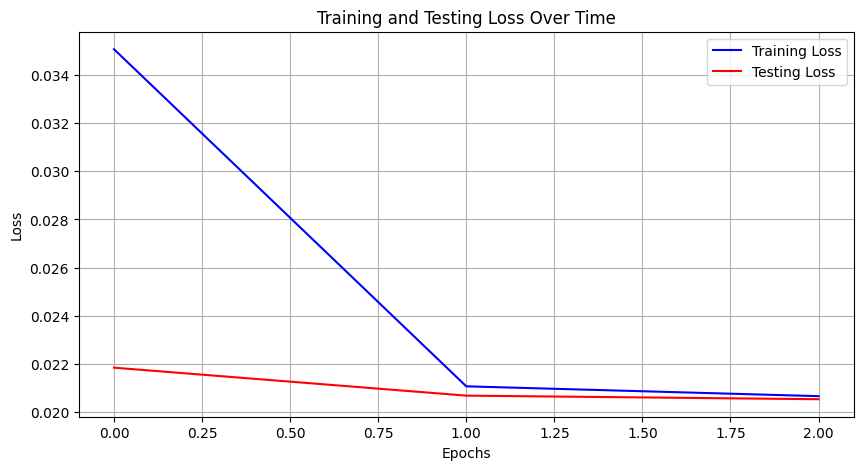

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define the Sudoku dataset class
class SudokuDataset(Dataset):
    def __init__(self, puzzles, solutions):
        self.puzzles = puzzles
        self.solutions = solutions

    def __len__(self):
        return len(self.puzzles)

    def __getitem__(self, idx):
        puzzle = self.puzzles[idx]
        solution = self.solutions[idx]
        return puzzle, solution

# Load the dataset from the .pt file
dataset_path = 'SudokuData/sudoku_dataset.pt'
sudoku_data = torch.load(dataset_path)

# Extract puzzles and solutions from the dataset
puzzles = sudoku_data['puzzles']
solutions = sudoku_data['solutions']

# Create the dataset and split into training and testing sets (80% training, 20% testing)
dataset = SudokuDataset(puzzles, solutions)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


batch_size = 1000

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Define a Convolutional Neural Network for solving Sudoku
class SudokuCNN(nn.Module):
    def __init__(self):
        super(SudokuCNN, self).__init__()
        # Input: (batch_size, 1, 9, 9), 1 channel for the 9x9 Sudoku puzzle
        
        # Convolutional layers
        n = 1
        self.conv1 = nn.Conv2d(1, 64*n, kernel_size=3, padding=1)  # Output: (batch_size, 32, 9, 9)
        self.conv2 = nn.Conv2d(64*n, 128*n, kernel_size=3, padding=1)  # Output: (batch_size, 64, 9, 9)
        self.conv3 = nn.Conv2d(128*n, 256*n, kernel_size=3, padding=1)  # Output: (batch_size, 128, 9, 9)
        self.conv4 = nn.Conv2d(256*n,512*n , kernel_size=3 ,padding=1)
       
        #self.dropout = nn.Dropout2d(0.08)
        
        # Fully connected layer to map to final 9x9 output
        self.fc1 = nn.Linear(512*n * 9 * 9, 81)  # Output: 81 (9x9 grid)
        
        self.relu = nn.ReLU()  # Activation function

    def forward(self, x):
        # Input: x of shape (batch_size, 1, 9, 9)
        x = self.relu(self.conv1(x))  # First convolution + ReLU
        x = self.relu(self.conv2(x))  # Second convolution + ReLU
        x = self.relu(self.conv3(x))  # Third convolution + ReLU
        x = self.relu(self.conv4(x))
       
        
        # Flatten the tensor before passing it to the fully connected layer
        x = x.view(x.size(0), -1)  # Flatten the output to (batch_size, 128 * 9 * 9)
        
        # Fully connected layer to predict the solved Sudoku
        x = self.fc1(x)  # Output shape: (batch_size, 81)
        
        # Reshape back to (batch_size, 9, 9) for the final grid
        return x.view(-1, 9, 9)

# Check if CUDA is available, and use it if it is
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Instantiate the model, move it to the GPU if available
model = SudokuCNN().to(device)
criterion = nn.MSELoss()  # Mean Squared Error Loss for regression
optimizer = optim.Adam(model.parameters(), lr=0.0008)

# Lists to track the loss for plotting
train_losses = []
test_losses = []

# Training and Testing loop with loading bar and loss visualization
num_epochs = 3
for epoch in range(num_epochs):
    print(f'Epoch [{epoch+1}/{num_epochs}]')

    # Training Phase
    model.train()  # Set the model to training mode
    train_loss = 0.0
    for batch_puzzles, batch_solutions in tqdm(train_loader, desc="Training", leave=False):
        # Move data to the device (GPU if available)
        batch_puzzles = batch_puzzles.view(-1, 1, 9, 9).float().to(device) / 9  # Reshape to (batch_size, 1, 9, 9)
        batch_solutions = batch_solutions.view(-1, 81).float().to(device) / 9
        
        # Forward pass through the model
        outputs = model(batch_puzzles)
        loss = criterion(outputs, batch_solutions.view(-1, 9, 9))
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * batch_puzzles.size(0)  # Accumulate loss

    # Average train loss for the epoch
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Testing Phase
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    with torch.no_grad():  # No need to track gradients during testing
        for batch_puzzles, batch_solutions in tqdm(test_loader, desc="Testing", leave=False):
            batch_puzzles = batch_puzzles.view(-1, 1, 9, 9).float().to(device) / 9  # Reshape to (batch_size, 1, 9, 9)
            batch_solutions = batch_solutions.view(-1, 81).float().to(device) / 9

            # Forward pass
            outputs = model(batch_puzzles)
            loss = criterion(outputs, batch_solutions.view(-1, 9, 9))

            test_loss += loss.item() * batch_puzzles.size(0)  # Accumulate test loss

    # Average test loss for the epoch
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    # Print losses for the epoch
    print(f'Training Loss: {train_loss:.4f}, Testing Loss: {test_loss:.4f}')

# Plot the loss curves for training and testing
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(test_losses, label='Testing Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()


In [16]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Function to test the model on n samples from the test dataset, utilizing GPU if available
def test_model(model, test_loader, n, device):
    model.eval()  # Set model to evaluation mode
    model.to(device)  # Move the model to the device (GPU or CPU)
    
    total_correct = 0
    total_cells = 0

    with torch.no_grad():  # No need to compute gradients during testing
        for i, (puzzles, solutions) in enumerate(test_loader):
            if i * puzzles.size(0) >= n:
                break  # Stop when we've tested n samples

            # Move puzzles and solutions to the device (GPU or CPU)
            puzzles = puzzles.view(-1, 1, 9, 9).float().to(device) / 9  # Normalized between 0 and 1
            solutions = solutions.view(-1, 9, 9).float().to(device)  # Original solutions reshaped

            # Forward pass
            outputs = model(puzzles)  # Model prediction

            # De-normalize and round predictions
            predicted = torch.round(outputs * 9).clamp(0, 9)  # Round and clip between 0-9
            true_values = solutions.view(-1, 9, 9)  # Reshape true solutions back to (batch_size, 9, 9)

            # Calculate number of correct guesses (element-wise comparison)
            correct = (predicted == true_values).sum().item()  # Count correct guesses
            total_correct += correct
            total_cells += predicted.numel()  # Total number of cells processed

    # Calculate accuracy as a percentage of correct guesses
    accuracy = (total_correct / total_cells) * 100
    print(f"Test Accuracy on {n} samples: {accuracy:.2f}%")
    return accuracy

# Example usage of the test_model function
# Set the number of samples to test (n)
n_samples_to_test = 10000  # Adjust this as needed

# Check if a GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the test dataset (ensure test_dataset is already defined and properly formatted)
test_loader = DataLoader(test_dataset, batch_size=10000, shuffle=True)

# Assuming your model is already trained, now test it
test_accuracy = test_model(model, test_loader, n_samples_to_test, device)



Test Accuracy on 10000 samples: 72.71%


In [17]:
torch.save(model.state_dict(), 'SudokuCNN1.pth')